In [1]:
!pip install -qU pandas langchain tiktoken matplotlib seaborn chromadb voyageai

In [5]:
import os
import pandas as pd

### Loading news jsons and parsing out the ids, titles, texts

In [14]:
df = pd.read_csv('calls.csv')

In [41]:
files = os.listdir('./news/2018_01_11')
titles = []
texts = []
ids = []
for file in files:
    with open('news/2018_01_11/{}'.format(file), 'r') as f:
            data = json.load(f)   
    ids.append(data['uuid'])
    titles.append(data['title'])
    texts.append(data['text'])

### Loading OpenAI tokenizer, visualizing the token lengths for the docs

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [118]:
doc_tokens_lens = [tiktoken_len(text) for text in texts]
print('avg token length per doc: {}'.format(sum(doc_tokens_lens)/len(texts)))

avg token length per doc: 505.5772118611813


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='Count'>

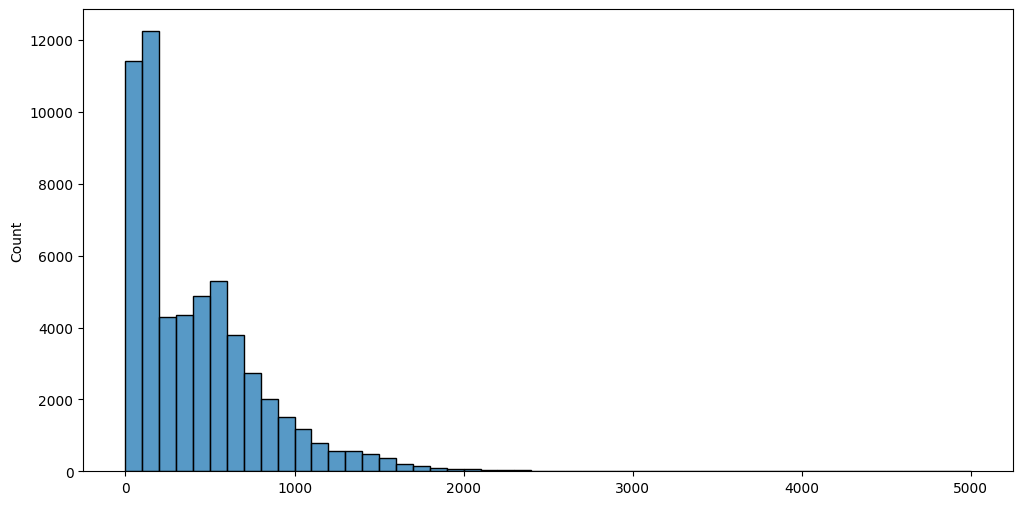

In [71]:
plt.figure(figsize = (12,6))
sns.histplot(doc_tokens_lens,kde = False, bins = 50,binrange = (0,5000))

### Customize the voyage AI Embedding Function classand create the vector DB with it

In [236]:
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings, Collection
class voyageai_ef(EmbeddingFunction):
    def __init__(self, api_key:str, model_name: str = 'voyage-large-2-instruct', batch_size: int = 100):
        """
        Initialize the VoyageAI EmbeddingFunction
        api_key: API key for the voyage API
        model_name: name of the embedding model
        """

        if not api_key:
            raise ValueError('Need an api key')

        try:
            import voyageai 
            from voyageai import get_embeddings

        except ImportError:
            raise ValueError('Need to install voyage ai python package')

        voyageai.api_key = api_key
        self.model = model_name
        self.batch_size = batch_size
        self.get_embeddings = get_embeddings        

    def __call__(self, texts: Documents) -> Embeddings:
        # embed the documents somehow
        batch_size = self.batch_size
        embeds = []
        for i in range(0, len(texts), batch_size):
            embeds.extend(self.get_embeddings(list_of_text = texts[i:i+batch_size], batch_size = batch_size, model = self.model))
        return embeds

In [ ]:
+ '_' + doc.metadata['id']

In [282]:
from typing import List

def split_text(titles: List[str], texts: List[str], ids: List[str]):
    docs = [titles[i] + texts[i] for i in range(len(texts))]
    documents = text_splitter.create_documents(docs,metadatas = [{'id' : id} for id in ids])
    return documents
def add_docs(docs:Documents, vector_db: Collection, batch_size: int = 200):
    for i in range(0, len(docs), batch_size):
        try:
            documents = docs[i:i+batch_size]
            collection.add(
                documents = [doc.page_content for doc in documents],
                #metadatas=[{"source": "kaggle"}],
                ids = [str(j) for j, doc in enumerate(documents)] # unique for each doc
            )
        except Exception as e:
            print(f'Failed vector insertion for {i,i+batch}th docs')
            print(e)
            
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # Size of each chunk in characters
    chunk_overlap=100,
    length_function=len,
    separators=["\n\n", "\n", " ", ".", ""])

In [287]:
client.delete_collection("news-articles")

In [288]:
api_key = "pa-y7suWFyb3w9NgW22Riey_qbkxDqBV9kzLmclvA4EV1M"
EF = voyageai_ef(api_key = api_key)

collection = client.create_collection("news-articles",embedding_function=EF)

In [228]:
documents = split_text(titles,texts,ids)
print(f"Splitted {len(texts)} documents into {len(documents)} chunks.")

Splitted 57802 documents into 185879 chunks.


In [289]:
add_docs(documents[:200],collection)

In [298]:
collection.query(query_texts = ["Tell me a bit about Argentina Merval stock index"]
                 #, n_results = 5
                 , where={'ids': '0'}
                 #where = 
                )

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None}

In [299]:
!pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 9.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:0000:0100:01


In [292]:
collection.query(query_texts = ["Tell me a bit about Argentina Merval stock index"], n_results = 5
                 #, where={'id': '2_4f2fec4a4d32d0f564e5da74188b51e5317e4826'}
                )

{'ids': [['2', '0', '1', '117', '32']],
 'distances': [[0.6230589747428894,
   0.7650056481361389,
   0.7671399116516113,
   0.8904033899307251,
   0.8977068066596985]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [["American equities rally to start the year that has MSCI's gauge of the region's stocks set for its largest January gains since 2006. The Merval closed up 0.55 percent at 35,141.72 points. Key Latin American stock indexes and currencies at 2145 GMT: Stock indexes Latest Daily YTD pct pct change change MSCI Emerging Markets 1,263.45 0.37 9.06 MSCI LatAm 3,201.95 1.01 13.22 Mexico IPC 50,777.90 0.27 3.09 Chile IPSA 5,811.54 0.23 4.44 Chile IGPA 29,216.54 0.23 4.42 Argentina Merval 35,141.72 0.55 16.88 Colombia IGBC 12,307.20 -0.06 8.24 Currencies Latest Daily YTD pct pct change change Brazil real 3.1470 0.35 5.28 Mexico peso 18.6100 -0.57 5.85 Chile peso 598.60 0.7 2.68 Colombia peso 2,790 0.84 6.88 Peru sol 3.210 0.09 0.84 Argentina pes

In [268]:
collection.

UUID('4bc66d2a-f2bc-4417-86a0-a5231c53cc24')

In [261]:
res

{'ids': [['2_4f2fec4a4d32d0f564e5da74188b51e5317e4826',
   '108_c18708491d5b9d6f4e0ad906824792bc18581f6c',
   '118_c18708491d5b9d6f4e0ad906824792bc18581f6c',
   '10_90c0db26f08bccf689b1970bfa5666dbcbbf5036',
   '20_90c0db26f08bccf689b1970bfa5666dbcbbf5036']],
 'distances': [[0.8524609804153442,
   0.873660147190094,
   0.873660147190094,
   0.8924012184143066,
   0.8925893306732178]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [["American equities rally to start the year that has MSCI's gauge of the region's stocks set for its largest January gains since 2006. The Merval closed up 0.55 percent at 35,141.72 points. Key Latin American stock indexes and currencies at 2145 GMT: Stock indexes Latest Daily YTD pct pct change change MSCI Emerging Markets 1,263.45 0.37 9.06 MSCI LatAm 3,201.95 1.01 13.22 Mexico IPC 50,777.90 0.27 3.09 Chile IPSA 5,811.54 0.23 4.44 Chile IGPA 29,216.54 0.23 4.42 Argentina Merval 35,141.72 0.55 16.88 Colombia IGBC 12,307.2

In [ ]:
def save_to_chroma(chunks: list[Document]):
  """
  Save the given list of Document objects to a Chroma database.
  Args:
  chunks (list[Document]): List of Document objects representing text chunks to save.
  Returns:
  None
  """

  # Clear out the existing database directory if it exists
  if os.path.exists(CHROMA_PATH):
    shutil.rmtree(CHROMA_PATH)

  # Create a new Chroma database from the documents using OpenAI embeddings
  db = Chroma.from_documents(
    chunks,
    OpenAIEmbeddings(),
    persist_directory=CHROMA_PATH
  )

  # Persist the database to disk
  db.persist()
  print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")